# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Esse projeto tem como objetivo criar um modelo de regressão linear para prever a renda dos clientes. 

Serão criados dois modelos:

    - um modelo utilizando Árvores de Regressão com a biblioteca sklearn
    - um modelo utilizando Regressão Linear com a biblioteca statsmodels.

Os algoritmos serão treinados a partir dos dados históricos do arquivo "previsao-renda.csv".


## Etapa 2 Crisp-DM: Entendimento dos dados

Foram fornecidas 14 variáveis mais a variável resposta ('renda', em negrito na tabela). O significado de cada uma dessas variáveis se encontra na tabela.

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. 

O dicionário de dados (explicação dessas variáveis) encontra-se logo abaixo.


### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 | Datetime |
| id_cliente              |  ID do cliente                                      | Inteiro |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | Binário |
| posse_de_veiculo        |  Y = 'possui'; N = 'não possui'                     | Binário |
| posse_de_imovel         |  Y = 'possui'; N = 'não possui'                     | Binário |
| qtd_filhos              |  Quantidade de filhos                               | Inteiro |
| tipo_renda              |  Tipo de renda (ex: assaláriado, autônomo, etc.)    | Texto |
| educacao                |  Nível de educação (ex: secundário, superior etc.)  | Texto |
| estado_civil            |  Estado civil (ex: solteiro, casado, etc.)          | Texto |
| tipo_residencia         |  Tipo de residência (ex: casa/apartamento, etc.)    | Texto |
| idade                   |  Idade em anos                                      | Inteiro |
| tempo_emprego           |  Tempo de emprego em anos                           | Inteiro |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | Inteiro |
| **renda**               |  **Renda mensal**                                   | **Decimal**|





#### Carregando os pacotes

In [18]:
#!pip install pandas-profiling

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as stm

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport


%matplotlib inline

#### Carregando os dados

Leitura do arquivo CSV:

In [177]:
df = pd.read_csv('./input/previsao-renda.csv')

print(f"Número de linhas/colunas = {df.shape}")

df.head(3)

Número de linhas/colunas = (16650, 16)


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,possui_celular,possui_fone_comercial,possui_fone,possui_email,qt_pessoas_residencia,mau
0,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,58.832877,3.106849,1,0,0,0,2.0,False
1,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,1.0,False
2,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,1.0,False


#### Entendimento dos dados - Univariada

- Para facilitar essa analise, será gerada uma página html com dados de cada variável através do ProfileReport, mas também serão analisadas uma a uma através do Python.

###### Geração do ProfileReport:

In [178]:
# Criação do profile
prof = ProfileReport(df, explorative=True, minimal=True)

# Salvar em html
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Pode-se conferir que a base não possui valores nulos/faltantes para nenhuma das colunas, porém o tipo de algumas variáveis precisam ser ajustados.

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   16650 non-null  object 
 1   posse_de_veiculo       16650 non-null  object 
 2   posse_de_imovel        16650 non-null  object 
 3   qtd_filhos             16650 non-null  int64  
 4   tipo_renda             16650 non-null  object 
 5   educacao               16650 non-null  object 
 6   estado_civil           16650 non-null  object 
 7   tipo_residencia        16650 non-null  object 
 8   idade                  16650 non-null  float64
 9   tempo_emprego          16650 non-null  float64
 10  possui_celular         16650 non-null  int64  
 11  possui_fone_comercial  16650 non-null  int64  
 12  possui_fone            16650 non-null  int64  
 13  possui_email           16650 non-null  int64  
 14  qt_pessoas_residencia  16650 non-null  float64
 15  ma

###### Variáveis binárias:

Variáveis estão bem distribuídas, aparentemente a única coisa a tratar é trocar os domínios para 0 e 1.

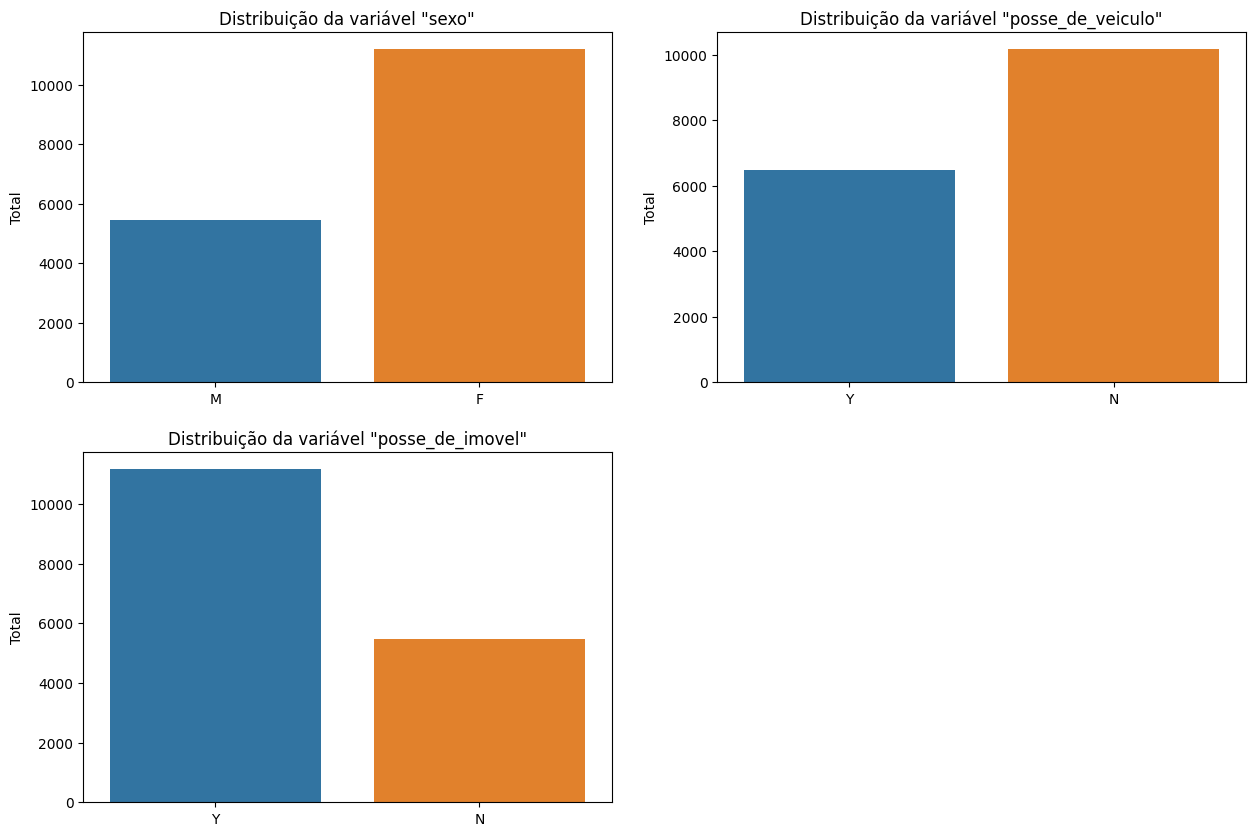

In [180]:
figura, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

sns.countplot(data = df, x = 'sexo', ax = ax1)
sns.countplot(data = df, x = 'posse_de_veiculo', ax = ax2)
sns.countplot(data = df, x = 'posse_de_imovel', ax = ax3)

ax1.set_title('Distribuição da variável "sexo"')
ax2.set_title('Distribuição da variável "posse_de_veiculo"')
ax3.set_title('Distribuição da variável "posse_de_imovel"')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.set_ylabel('Total')
ax2.set_ylabel('Total')
ax3.set_ylabel('Total')

ax4.remove()

###### Variáveis numéricas

* idade: apresenta uma boa distribuição e não precisará ser tratada.
* tempo_emprego: possui valores negativos que não fazem sentido existir, deverão ser tratados. Também possui outliers superiores.
* qtd_filhos: possui outliers que deverãos ser tratados.
* qt_pessoas_residencia: possui outliers que deverãos ser tratados.

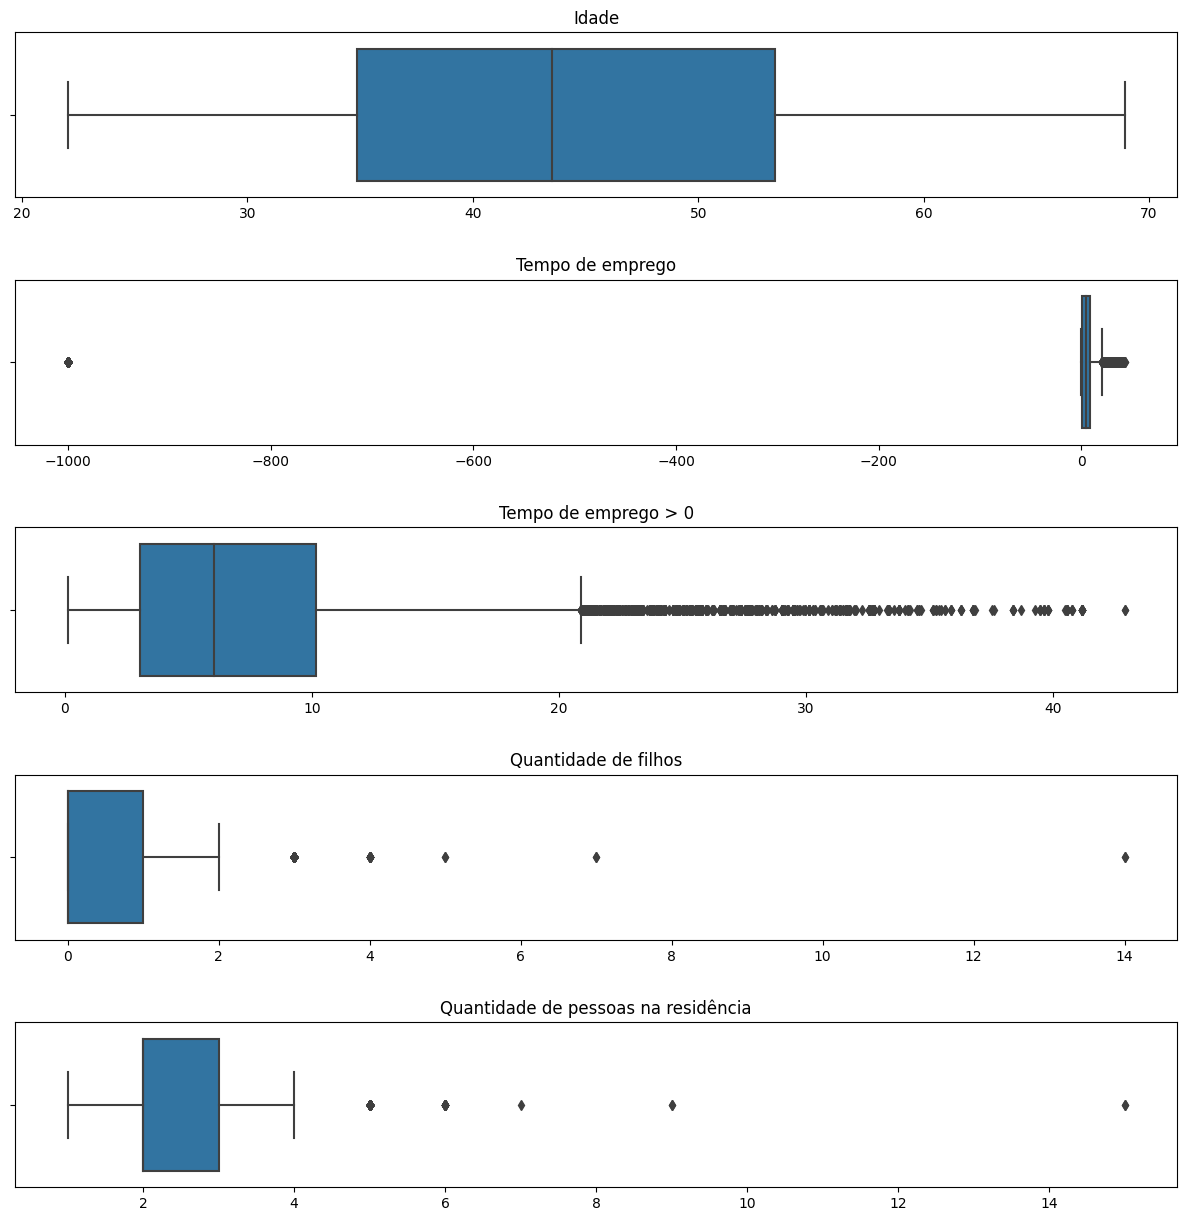

,count,mean,std,min,25%,50%,75%,max
idade,16650.0,44.319513,11.228837,22.030137,34.873973,43.493151,53.410959,68.909589
tempo_emprego,16650.0,-161.416446,376.843912,-1000.665753,1.183562,4.691781,9.088356,42.906849
qtd_filhos,16650.0,0.433153,0.739395,0.000000,0.000000,0.000000,1.000000,14.000000
qt_pessoas_residencia,16650.0,2.211892,0.903755,1.000000,2.000000,2.000000,3.000000,15.000000


In [239]:
figura, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15, 15))

sns.boxplot(data = df, x = 'idade', ax = ax1)
sns.boxplot(data = df, x = 'tempo_emprego', ax = ax2)
sns.boxplot(data = df[df['tempo_emprego']>0], x = 'tempo_emprego', ax = ax3)
sns.boxplot(data = df, x = 'qtd_filhos', ax = ax4)
sns.boxplot(data = df, x = 'qt_pessoas_residencia', ax = ax5)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')

ax1.set_title('Idade')
ax2.set_title('Tempo de emprego')
ax3.set_title('Tempo de emprego > 0')
ax4.set_title('Quantidade de filhos')
ax5.set_title('Quantidade de pessoas na residência')

figura.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()

df[ ['idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'] ].describe().transpose()

In [ ]:
tipo_renda             16650 non-null  object 
 5   educacao               16650 non-null  object 
 6   estado_civil           16650 non-null  object 
 7   tipo_residencia 

###### Variáveis categóricas

Todas as variáveis possuem uma categoria com pouca frequência, que pode acabar atrapalhando o modelo.

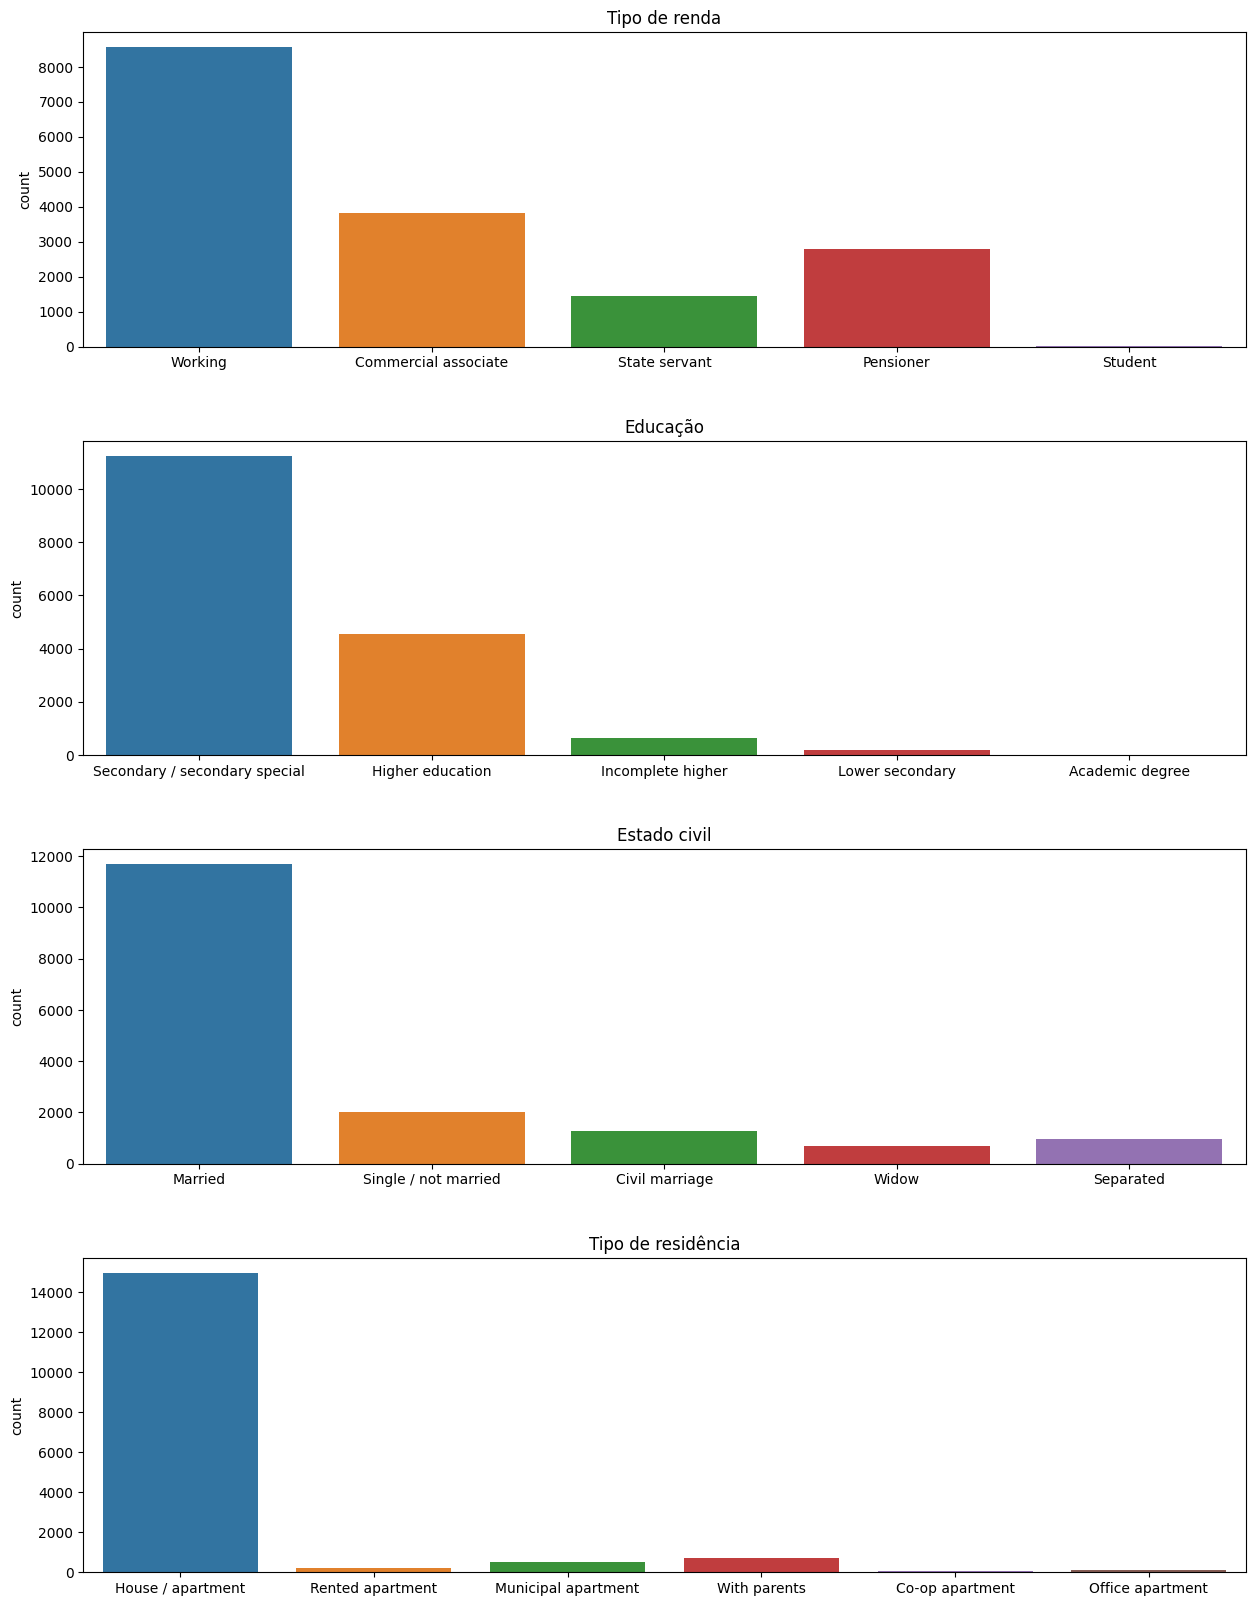

In [251]:
figura, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))

sns.countplot(data = df, x = 'tipo_renda', ax = ax1)
sns.countplot(data = df, x = 'educacao', ax = ax2)
sns.countplot(data = df, x = 'estado_civil', ax = ax3)
sns.countplot(data = df, x = 'tipo_residencia', ax = ax4)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_title('Tipo de renda')
ax2.set_title('Educação')
ax3.set_title('Estado civil')
ax4.set_title('Tipo de residência')

figura.subplots_adjust(hspace=0.3, wspace=0.5)

### Entendimento dos dados - Bivariadas




<span style="color:red">ESCREVER AQUI</span>


## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



<span style="color:red">ESCREVER AQUI</span>


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:red">ESCREVER AQUI</span>


### Rodando o modelo


<span style="color:red">ESCREVER AQUI</span>


## Etapa 5 Crisp-DM: Avaliação dos resultados


<span style="color:red">ESCREVER AQUI</span>


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.